# Time forecasting model for GHG emissions

The time forecasting of GHG emissions from pre-corona data will give us an estimate of what our current emissions would be without corona. The difference between this and our actual data will be our daily emissions savings. The following model is an ARIMA (Auto Regressive Integrated Moving Average) following this article: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

## Import libraries

In [190]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

## Load data

In [191]:
file_name = 'uk_energy_daily.csv'
data_dir = 'data/processed'
file_path = os.path.join(data_dir, file_name)
test_df = pd.read_csv(file_path, usecols = ["demand", "timestamp"])
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
test_df.set_index(["timestamp"], inplace=True)
test_df = test_df.groupby(pd.Grouper(freq='W')).mean()

In [192]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 474 entries, 2011-05-29 to 2020-06-21
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  474 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


In [193]:
test_df.head()

,demand
timestamp,
2011-05-29,31179.960783
2011-06-05,32792.248598
2011-06-12,33820.311689
2011-06-19,33482.346304
2011-06-26,33668.414294


In [194]:
test_df.describe()

,demand
count,474.000000
mean,33188.863665
std,4533.280002
min,21561.985148
25%,29739.789762
50%,32833.808994
75%,36448.814926
max,47147.795911


## Transform data to be stationary

Define stationary test function

In [195]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling('365D').mean()
    rolling_std = timeseries.rolling('365D').std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey–Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic: {:.3f}'.format(result[0]))
    print('p-value: {:.3f}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))

#     # KPSS test
#     result = kpss(timeseries, 'ct')
#     print("KPSS statistic = {:.3f}".format(result[0]))
#     print("p-value = {:.3f}".format(result[1]))
#     print("Critical values :")
#     for k, v in result[3].items():
#         print("\t{}: {:.3f}".format(k, v))

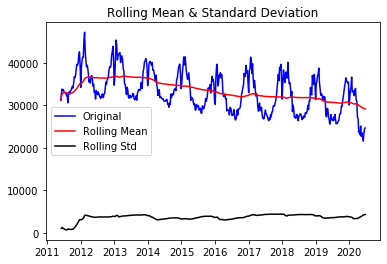

ADF Statistic: -5.176
p-value: 0.000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [196]:
get_stationarity(test_df)

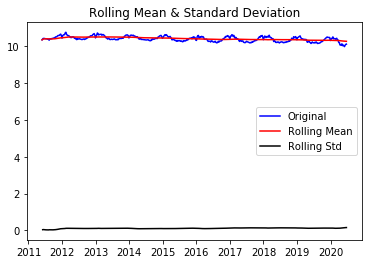

ADF Statistic: -4.802
p-value: 0.000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [197]:
df_log = np.log(test_df)
get_stationarity(df_log)

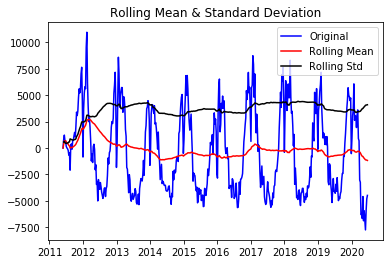

ADF Statistic: -8.435
p-value: 0.000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [198]:
rolling_mean = test_df.rolling('365D').mean()
test_df_minus_mean = test_df - rolling_mean
test_df_minus_mean.dropna(inplace=True)
get_stationarity(test_df_minus_mean)

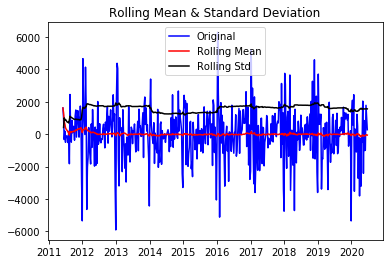

ADF Statistic: -6.477
p-value: 0.000
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [199]:
test_df_shift = test_df - test_df.shift()
test_df_shift.dropna(inplace=True)
get_stationarity(test_df_shift)

In [200]:
chosen_df = test_df_shift

## Plot autocorrelations

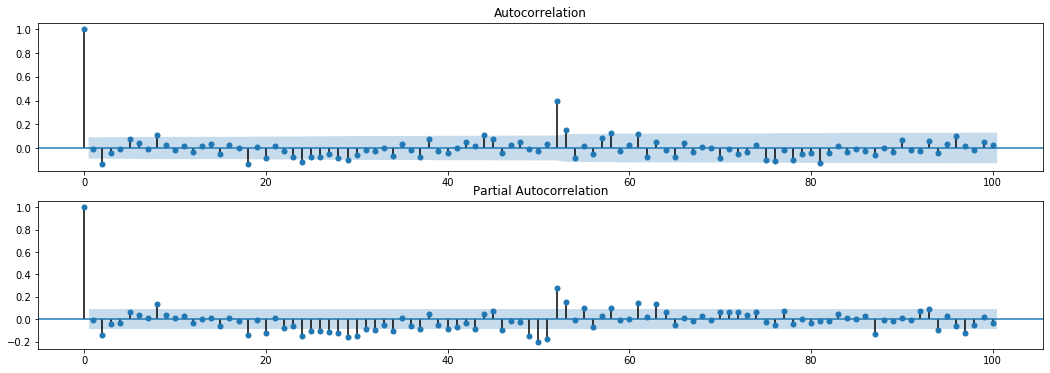

In [201]:
fig, ax = plt.subplots(2, figsize=(18,6))
ax[0]=plot_acf(chosen_df, ax=ax[0], lags=100)
ax[1]=plot_pacf(chosen_df, ax=ax[1], lags=100)

## Explore d values

5067.905158729949
                              ARMA Model Results                              
Dep. Variable:                 demand   No. Observations:                  474
Model:                     ARMA(0, 0)   Log Likelihood               -4662.778
Method:                           css   S.D. of innovations           4528.496
Date:                Wed, 17 Jun 2020   AIC                           9329.555
Time:                        23:06:14   BIC                           9337.878
Sample:                    05-29-2011   HQIC                          9332.828
                         - 06-21-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.319e+04    208.001    159.561      0.000    3.28e+04    3.36e+04


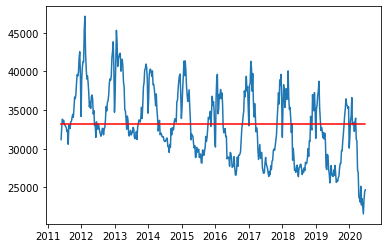

In [207]:
decomposition = seasonal_decompose(test_df) 
model = ARIMA(test_df, order=(0,0,0), freq='W')
result = model.fit()
plt.plot(test_df)
plt.plot(results.fittedvalues, color='red')
print(np.std(results.resid.values))
print(result.summary())

5067.905158729949
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                  473
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4159.043
Method:                           css   S.D. of innovations           1593.941
Date:                Wed, 17 Jun 2020   AIC                           8322.087
Time:                        23:06:15   BIC                           8330.405
Sample:                    06-05-2011   HQIC                          8325.358
                         - 06-21-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.7329     73.289     -0.187      0.851    -157.378     129.912


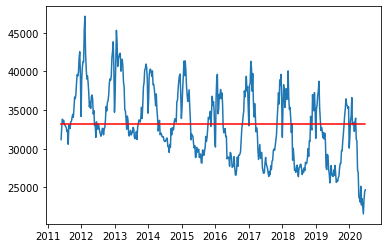

In [208]:
decomposition = seasonal_decompose(test_df) 
model = ARIMA(test_df, order=(0,1,0), freq='W')
result = model.fit()
plt.plot(test_df)
plt.plot(results.fittedvalues, color='red')
print(np.std(results.resid.values))
print(result.summary())

5067.905158729949
                             ARIMA Model Results                              
Dep. Variable:              D2.demand   No. Observations:                  472
Model:                 ARIMA(0, 2, 0)   Log Likelihood               -4315.090
Method:                           css   S.D. of innovations           2260.182
Date:                Wed, 17 Jun 2020   AIC                           8634.179
Time:                        23:06:16   BIC                           8642.493
Sample:                    06-12-2011   HQIC                          8637.450
                         - 06-21-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8394    104.033     -0.027      0.978    -206.741     201.062


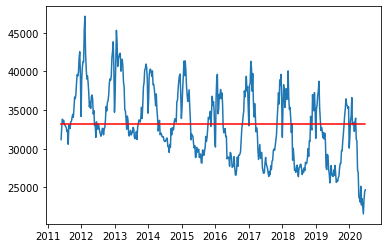

In [209]:
decomposition = seasonal_decompose(test_df) 
model = ARIMA(test_df, order=(0,2,0), freq='W')
result = model.fit()
plt.plot(test_df)
plt.plot(results.fittedvalues, color='red')
print(np.std(results.resid.values))
print(result.summary())

## Explore d values

5067.905158729949
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                  473
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4159.043
Method:                           css   S.D. of innovations           1593.941
Date:                Wed, 17 Jun 2020   AIC                           8322.087
Time:                        23:06:17   BIC                           8330.405
Sample:                    06-05-2011   HQIC                          8325.358
                         - 06-21-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.7329     73.289     -0.187      0.851    -157.378     129.912


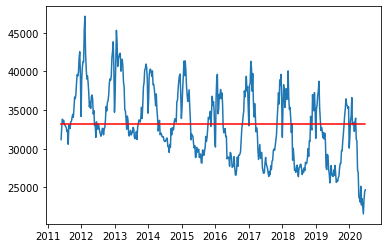

In [210]:
decomposition = seasonal_decompose(test_df) 
model = ARIMA(test_df, order=(0,1,0), freq='W')
result = model.fit()
plt.plot(test_df)
plt.plot(results.fittedvalues, color='red')
print(np.std(results.resid.values))
print(result.summary())

5067.905158729949
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                  473
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4159.039
Method:                       css-mle   S.D. of innovations           1593.926
Date:                Wed, 17 Jun 2020   AIC                           8324.078
Time:                        23:06:18   BIC                           8336.555
Sample:                    06-05-2011   HQIC                          8328.985
                         - 06-21-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -13.6179     72.972     -0.187      0.852    -156.641     129.405
ar.L1.D.demand    -0.0043      0.046     -0.095      0.925      -0.094       0.086
                  

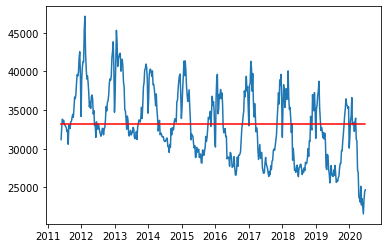

In [211]:
decomposition = seasonal_decompose(test_df) 
model = ARIMA(test_df, order=(1,1,0), freq='W')
result = model.fit()
plt.plot(test_df)
plt.plot(results.fittedvalues, color='red')
print(np.std(results.resid.values))
print(result.summary())

5067.905158729949
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                  473
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4154.602
Method:                       css-mle   S.D. of innovations           1578.982
Date:                Wed, 17 Jun 2020   AIC                           8317.204
Time:                        23:06:19   BIC                           8333.841
Sample:                    06-05-2011   HQIC                          8323.748
                         - 06-21-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -14.7500     63.636     -0.232      0.817    -139.474     109.974
ar.L1.D.demand    -0.0052      0.046     -0.114      0.910      -0.094       0.084
ar.L2.D.demand    

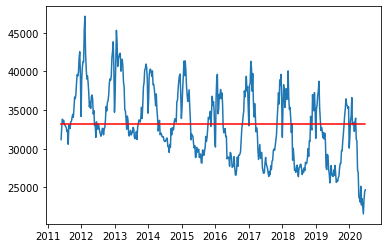

In [212]:
decomposition = seasonal_decompose(test_df) 
model = ARIMA(test_df, order=(2,1,0), freq='W')
result = model.fit()
plt.plot(test_df)
plt.plot(results.fittedvalues, color='red')
print(np.std(results.resid.values))
print(result.summary())

## Explore q values

5067.905158729949
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                  473
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4154.602
Method:                       css-mle   S.D. of innovations           1578.982
Date:                Wed, 17 Jun 2020   AIC                           8317.204
Time:                        23:06:24   BIC                           8333.841
Sample:                    06-05-2011   HQIC                          8323.748
                         - 06-21-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -14.7500     63.636     -0.232      0.817    -139.474     109.974
ar.L1.D.demand    -0.0052      0.046     -0.114      0.910      -0.094       0.084
ar.L2.D.demand    

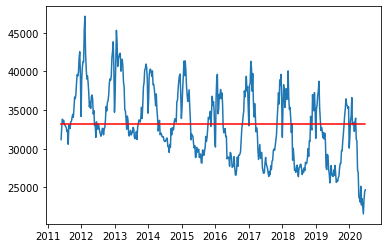

In [213]:
decomposition = seasonal_decompose(test_df) 
model = ARIMA(test_df, order=(2,1,0), freq='W')
result = model.fit()
plt.plot(test_df)
plt.plot(results.fittedvalues, color='red')
print(np.std(results.resid.values))
print(result.summary())

5067.905158729949
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                  473
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -4154.183
Method:                       css-mle   S.D. of innovations           1577.574
Date:                Wed, 17 Jun 2020   AIC                           8318.365
Time:                        23:06:30   BIC                           8339.160
Sample:                    06-05-2011   HQIC                          8326.544
                         - 06-21-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -15.2414     60.614     -0.251      0.801    -134.042     103.559
ar.L1.D.demand     0.2445      0.232      1.053      0.292      -0.211       0.700
ar.L2.D.demand    

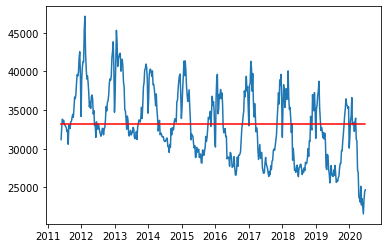

In [214]:
decomposition = seasonal_decompose(test_df) 
model = ARIMA(test_df, order=(2,1,1), freq='W')
result = model.fit()
plt.plot(test_df)
plt.plot(results.fittedvalues, color='red')
print(np.std(results.resid.values))
print(result.summary())

5067.905158729949
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                  473
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4153.871
Method:                       css-mle   S.D. of innovations           1576.523
Date:                Wed, 17 Jun 2020   AIC                           8319.742
Time:                        23:06:33   BIC                           8344.697
Sample:                    06-05-2011   HQIC                          8329.557
                         - 06-21-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -15.2709     60.774     -0.251      0.802    -134.387     103.845
ar.L1.D.demand     0.5459      0.426      1.282      0.200      -0.289       1.380
ar.L2.D.demand    

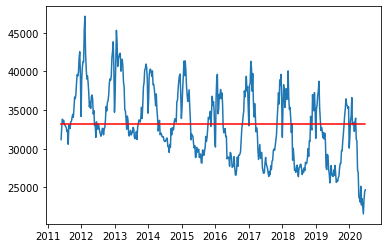

In [215]:
decomposition = seasonal_decompose(test_df) 
model = ARIMA(test_df, order=(2,1,2), freq='W')
result = model.fit()
plt.plot(test_df)
plt.plot(results.fittedvalues, color='red')
print(np.std(results.resid.values))
print(result.summary())